[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/tp/01_aprendizaje_supervisado/tp01-enunciado.ipynb)

# Trabajo Práctico -  Aprendizaje supervisado
## 1C2025 Grupo Data Sapiens


# Ejercicio 1 - separacion de datos


In [ ]:
import pandas as pd

def train_test_split(data, porcentaje=0.2, seed=0):
  data = data.sample(n=len(data), random_state=seed) # shuffle inicial

  data_0 = data[data['target']==0] # separamos ambas clases
  data_1 = data[data['target']==1]

  data_0_eval  = data_0[0:round(len(data_0)*porcentaje)] # separamos una porción de la clase 0.
  data_0_dev = data_0[round(len(data_0)*porcentaje):]
  data_1_eval  = data_1[0:round(len(data_1)*porcentaje)] # separamos una porción de la clase 1.
  data_1_dev = data_1[round(len(data_1)*porcentaje):]

  data_dev = pd.concat([data_0_dev, data_1_dev]) # juntamos ambas clases
  data_eval  = pd.concat([data_0_eval, data_1_eval])

  X_dev = data_dev[data_dev.columns[:-1]] # partimos el dataset en atributos (X) y clases (y):
  y_dev = data_dev[data_dev.columns[-1]]
  X_eval = data_eval[data_eval.columns[:-1]]
  y_eval = data_eval[data_eval.columns[-1]]

  return X_dev, y_dev, X_eval, y_eval

data = pd.read_csv('data.csv')
X_dev, y_dev, X_eval, y_eval = train_test_split(data, seed=2025)


In [ ]:
data.head(5)

,QqgU,IJsJ,YlJA,tFLR,MYkJ,Cado,cmdU,AUYy,mVEY,zSZq,...,cgNV,naPw,EOre,sMSU,TihR,sbWq,aWBQ,fGxK,JWOq,target
0,-0.753155,-0.304399,0.307146,-1.377240,-1.975242,-0.052628,0.430082,-0.659100,4.897377,0.754531,...,0.975926,-0.593156,0.315798,0.546475,1.128513,7.654107,0.563439,0.322854,-1.754513,0
1,0.660977,-1.374880,-0.039899,-0.157981,-0.263226,-0.035127,1.583745,-0.143602,12.945694,-0.347768,...,-0.274560,0.205678,-0.296301,-1.004013,7.090070,0.182824,0.113722,1.323722,0.710734,0
2,1.906825,-0.308091,1.115546,0.093203,-1.384119,0.616543,0.384448,-0.817921,-7.673495,1.028706,...,-0.369924,-0.678204,1.564510,0.314275,-4.246162,-1.941577,-0.566316,-0.261689,-1.715006,1
3,3.767180,-0.495569,-0.654660,0.101866,0.644159,1.978273,-1.087526,0.925767,10.392570,0.203025,...,0.252199,-0.200540,1.043750,-0.039129,-2.898566,-5.231800,-0.476618,-0.300148,0.315923,0
4,3.540548,0.544672,-1.820594,0.068094,0.844530,-0.516157,0.561619,1.634488,1.220771,-0.344691,...,-2.380954,1.532346,-1.594870,-1.809599,-0.445860,-0.169324,1.876894,-0.043769,1.529304,0


In [ ]:
data['target'].value_counts()


,count
target,
0,349
1,151


# Ejercicio 2 - Construcción de modelos



In [ ]:
# Entrenamos un arbol de decisión - Creamos un arbol de altura 3, con sus hiperparámetros defaul

from sklearn.tree import DecisionTreeClassifier
#Entrena un arbol segun los datos e hiperparametros pasados
def train_tree(X_train, y_train, max_depth, criterion = "gini") -> DecisionTreeClassifier:
    arbol = DecisionTreeClassifier(max_depth = max_depth, criterion=criterion)
    arbol.fit(X_train, y_train)

    return arbol

In [ ]:
# Devueve las predicciones de train y test de un arbol entrenado
def tree_predict(ab: DecisionTreeClassifier, X_train, X_test) :
    predictions_train = ab.predict(X_train)
    predictions_test = ab.predict(X_test)
    return predictions_train, predictions_test

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# creamos el arbol y lo entrenamos
arbol = train_tree(X_dev, y_dev, max_depth=3)

In [ ]:
## Estimando la performance con validación cruzada

# Utilizamos K-fold cross validation con K=5.

# las métricas que utilizamos son:
# * Accuracy
# * Area Under the Precision-Recall Curve (AUPRC)
# * Area Under the Receiver Operating Characteristic Curve (AUCROC).

import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, cross_validate, KFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve

In [ ]:
def cross_validation(X_train, y_train, max_depth = 3, criterion = "gini"):

  kf = StratifiedKFold(n_splits=5)
  #
  y_pred = np.empty(y_train.shape)
  y_pred.fill(np.nan)

  y_pred_proba = np.empty(y_train.shape)
  y_pred_proba.fill(np.nan)

  accuraciesTest = []
  accuraciesTrain = []

  aucprcTest = []
  aucprcTrain = []

  aucrocTest = []
  aucrocTrain = []

  #iteramos entre los folds
  for train_index, test_index in kf.split(X_train, y_train):

      #separamos los fold de train y test
      kf_X_train, kf_X_test = X_train.iloc[train_index], X_train.iloc[test_index]
      kf_y_train, kf_y_test = y_train.iloc[train_index], y_train.iloc[test_index]
      #entrenamos el arbol
      current_tree = train_tree(kf_X_train, kf_y_train,
                                    max_depth,criterion)
      #Obtenemos las predicciones
      predicciones_train, predicciones_test = tree_predict(current_tree, kf_X_train, kf_X_test)
      predicciones_proba_train = current_tree.predict_proba(kf_X_train)[:,1]
      predicciones_proba_test  = current_tree.predict_proba(kf_X_test)[:,1]

      #Calculamos los scores por separado
      accuraciesTrain.append(accuracy_score(kf_y_train, predicciones_train))
      accuraciesTest.append(accuracy_score(kf_y_test, predicciones_test))

      aucprcTrain.append(average_precision_score(kf_y_train, predicciones_proba_train))
      aucprcTest.append(average_precision_score(kf_y_test, predicciones_proba_test))

      aucrocTrain.append(roc_auc_score(kf_y_train, predicciones_proba_train))
      aucrocTest.append(roc_auc_score(kf_y_test, predicciones_proba_test))

      #Guardamos para luego calcular el global
      y_pred[test_index] = predicciones_test
      y_pred_proba[test_index] = predicciones_proba_test

  accGlobal = accuracy_score(y_train, y_pred)
  aucprcGlobal = average_precision_score(y_train, y_pred_proba)
  aucrocGlobal = roc_auc_score(y_train, y_pred_proba)

  return accGlobal, aucprcGlobal,aucrocGlobal,accuraciesTrain, accuraciesTest,aucprcTrain, aucprcTest,aucrocTrain, aucrocTest



In [ ]:

accGlobal, aucprcGlobal, aucrocGlobal, accuraciesTrain, accuraciesTest,aucprcTrain,aucprcTest,aucrocTrain,aucrocTest = cross_validation(X_dev, y_dev)

print(f"accGlobal:{accGlobal} aucprcGlobal:{aucprcGlobal} aucrocGlobal:{aucrocGlobal}")

print(f"accuraciesTrain:{accuraciesTrain}")
print(f"accuraciesTest:{accuraciesTest}")

print(f"aucprcTrain:{aucprcTrain}")
print(f"aucprcTest:{aucprcTest}")

print(f"aucrocTrain:{aucrocTrain}")
print(f"aucrocTest:{aucrocTest}")


accGlobal:0.7225 aucprcGlobal:0.4138731711331126 aucrocGlobal:0.6050534672235552
accuraciesTrain:[0.821875, 0.8375, 0.853125, 0.8375, 0.821875]
accuraciesTest:[0.7375, 0.7, 0.725, 0.6625, 0.7875]
aucprcTrain:[np.float64(0.6821981715772173), np.float64(0.699527665805167), np.float64(0.6944016329168599), np.float64(0.739077151211377), np.float64(0.68503102289867)]
aucprcTest:[np.float64(0.3947700691121744), np.float64(0.32229965156794427), np.float64(0.37203703703703705), np.float64(0.4642506763634415), np.float64(0.5359090909090909)]
aucrocTrain:[np.float64(0.8369238592760391), np.float64(0.8499607045444039), np.float64(0.7912717858628818), np.float64(0.8525958115667329), np.float64(0.8054547991071429)]
aucrocTest:[np.float64(0.6041666666666666), np.float64(0.4832589285714286), np.float64(0.5970982142857142), np.float64(0.6897321428571428), np.float64(0.6887272727272727)]


In [ ]:
#Codigo para armar y printear la tabla


crossValidationData = { # reporte de scoring por fold
    "Permutación": [1, 2, 3, 4, 5],
    "Accuracy (training)": accuraciesTrain,
    "Accuracy (validación)": accuraciesTest,
    "AUCPRC (training)": aucprcTrain,
    "AUCPRC (validación)": aucprcTest,
    "AUC-ROC (training)": aucrocTrain,
    "AUC-ROC (validación)": aucrocTest
}

crossValidationFrame = pd.DataFrame(crossValidationData)

promedios = pd.DataFrame([ # reporte de scorings promediando folds
    {"Permutación": "Promedios",
     "Accuracy (training)": np.array(accuraciesTrain).mean(),
     "Accuracy (validación)": np.array(accuraciesTest).mean(),
     "AUCPRC (training)": np.array(aucprcTrain).mean(),
     "AUCPRC (validación)": np.array(aucprcTest).mean(),
     "AUC-ROC (training)": np.array(aucrocTrain).mean(),
     "AUC-ROC (validación)": np.array(aucrocTest).mean()
    }])

globales = pd.DataFrame([
    {"Permutación": "Globales",
     "Accuracy (training)": "(NO)",
     "Accuracy (validación)": accGlobal,
     "AUCPRC (training)": "(NO)",
     "AUCPRC (validación)": aucprcGlobal,
     "AUC-ROC (training)": "(NO)",
     "AUC-ROC (validación)": aucrocGlobal
    }])

crossValidationFrame = pd.concat([crossValidationFrame, promedios], ignore_index=True) # juntamos las lineas de la grilla
crossValidationFrame = pd.concat([crossValidationFrame, globales], ignore_index=True)

display(crossValidationFrame) # mostramos la grilla con los resultados de la validación cruzada


,Permutación,Accuracy (training),Accuracy (validación),AUCPRC (training),AUCPRC (validación),AUC-ROC (training),AUC-ROC (validación)
0,1,0.821875,0.7375,0.682198,0.394770,0.836924,0.604167
1,2,0.8375,0.7000,0.699528,0.322300,0.849961,0.483259
2,3,0.853125,0.7250,0.694402,0.372037,0.791272,0.597098
3,4,0.8375,0.6625,0.739077,0.464251,0.852596,0.689732
4,5,0.821875,0.7875,0.685031,0.535909,0.805455,0.688727
5,Promedios,0.834375,0.7225,0.700047,0.417853,0.827241,0.612597
6,Globales,(NO),0.7225,(NO),0.413873,(NO),0.605053


In [ ]:
from sklearn.model_selection import ParameterGrid

# Exploramos los scores con diferentes alturas y criterios en arboles de decision
param_grid = {'max_depth': [3,5,None],
 'criterion': ["gini","entropy"]}
manual_grid= list(ParameterGrid(param_grid))
results=[]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for params in manual_grid:
  #Usamos las funcion definida anteriormente

  #cambiamos la salida de cv hay que arreglar esto
  accGlobal, aucprcGlobal, aucrocGlobal, accuraciesTrain, accuraciesTest,aucprcTrain,aucprcTest,aucrocTrain,aucrocTest = \
      cross_validation(X_dev, y_dev, max_depth=params['max_depth'], criterion=params['criterion'])
  #Calculamos los score promedio
  accurracy_test = np.array(accuraciesTest).mean()
  accurracy_train = np.array(accuraciesTrain).mean()

  results.append(
      {'max_depth': params['max_depth'],'criterion':params['criterion'],'Accuracy(training)':accurracy_train,
       'Accuracy(validación)':accurracy_test}
  )
table_results= pd.DataFrame(results)
table_results

,max_depth,criterion,Accuracy(training),Accuracy(validación)
0,3.0,gini,0.834375,0.7250
1,5.0,gini,0.925625,0.7175
2,NaN,gini,1.000000,0.6825
3,3.0,entropy,0.811250,0.6750
4,5.0,entropy,0.901250,0.6775
5,NaN,entropy,1.000000,0.6400


## Ejercicio 3 - Comparación de algoritmos

In [ ]:
import scipy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.stats import loguniform, uniform
from math import ceil
import time

In [ ]:
# busqueda de la mejor hyper-parametrización con RandomizeSearchCV para arboles de decisión
t = time.time()
DecisionTreeClassifier().get_params()

hiperparams = {'criterion': ['gini', 'entropy'],
               'max_depth': range(3,15),
               'min_impurity_decrease': loguniform(1e-3, 5e-1),
               'min_samples_split': range(2,15)}

arbol = DecisionTreeClassifier()
clf = RandomizedSearchCV(arbol, hiperparams, n_iter=1000, cv=5, scoring='roc_auc', random_state=2025)
search_arbol = clf.fit(X_dev, y_dev)
print("Score máximo: ", search_arbol.best_score_)
print("Mejores Parámetros Encontrados: ", search_arbol.best_params_)
print("Tiempo transcurrido: ", time.time()-t)

Score máximo:  0.6623360389610389
Mejores Parámetros Encontrados:  {'criterion': 'gini', 'max_depth': 13, 'min_impurity_decrease': np.float64(0.0010558841925847806), 'min_samples_split': 7}
Tiempo transcurrido:  158.6908712387085


In [ ]:
# busqueda de la mejor hyper-parametrización con RandomizeSearchCV para KNN
t = time.time()
KNeighborsClassifier().get_params()

hiperparams = {'n_neighbors': range(2,50),
               'weights': ['uniform', 'distance'],
               'p': uniform(1,3)}

KNN = KNeighborsClassifier()
clf = RandomizedSearchCV(KNN, hiperparams, n_iter=200, cv=5, scoring='roc_auc', random_state=2025)
search_knn = clf.fit(X_dev, y_dev)

print("Score máximo: ", search_knn.best_score_)
print("Mejores Parámetros Encontrados: ", search_knn.best_params_)
print("Tiempo transcurrido: ", time.time()-t)

Score máximo:  0.8701640692640693
Mejores Parámetros Encontrados:  {'n_neighbors': 13, 'p': np.float64(1.1513812131738241), 'weights': 'distance'}
Tiempo transcurrido:  87.54502415657043


In [ ]:
# busqueda de la mejor hyper-parametrización con RandomizeSearchCV para SVC
t = time.time()
SVC().get_params()

hiperparams = {'C': loguniform(1, 50),
               'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
               'gamma': loguniform(1e-6, 1e-3)}

svc = SVC()
clf = RandomizedSearchCV(svc, hiperparams, n_iter=1000, cv=5, scoring='roc_auc', random_state=2025)
search_svc = clf.fit(X_dev, y_dev)

print("Score máximo: ", search_svc.best_score_)
print("Mejores Parámetros Encontrados: ", search_svc.best_params_)
print("Tiempo transcurrido: ", time.time()-t)

Score máximo:  0.9254016233766234
Mejores Parámetros Encontrados:  {'C': np.float64(37.70561520977166), 'gamma': np.float64(0.0001248558712834043), 'kernel': 'rbf'}
Tiempo transcurrido:  85.3624222278595


In [ ]:
#3.2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

In [ ]:
# Scores de LDA (Linear Discriminant Analysis) usando K-fold stratified cross-validation
lda = LinearDiscriminantAnalysis()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lda_scores = []

for train_index, test_index in kf.split(X_dev, y_dev):
    X_train, X_test = X_dev.iloc[train_index], X_dev.iloc[test_index]
    y_train, y_test = y_dev.iloc[train_index], y_dev.iloc[test_index]

    lda.fit(X_train, y_train)
    y_predict_proba = lda.predict_proba(X_test)[:, 1]
    lda_scores.append(roc_auc_score(y_test, y_predict_proba))

print(np.mean(lda_scores))



# Scores de Naive Bayes usando K-fold stratified cross-validation
nb=GaussianNB()
nb_scores = []
for train_index, test_index in kf.split(X_dev, y_dev):
    X_train, X_test = X_dev.iloc[train_index], X_dev.iloc[test_index]
    y_train, y_test = y_dev.iloc[train_index], y_dev.iloc[test_index]
    nb.fit(X_train, y_train)
    y_predict_proba = nb.predict_proba(X_test)[:,1]
    nb_scores.append(roc_auc_score(y_test, y_predict_proba))
print(np.mean(nb_scores))



# Scores de Dummy usando K-fold stratified cross-validation
dummy= DummyClassifier(strategy='most_frequent')
dummy_scores = []
for train_index, test_index in kf.split(X_dev, y_dev):
    X_train, X_test = X_dev.iloc[train_index], X_dev.iloc[test_index]
    y_train, y_test = y_dev.iloc[train_index], y_dev.iloc[test_index]
    dummy.fit(X_train, y_train)
    y_predict_proba = dummy.predict_proba(X_test)[:,1]
    dummy_scores.append(roc_auc_score(y_test, y_predict_proba))

print(np.mean(dummy_scores))


0.6823648268398268
0.812892316017316
0.5


## Ejercicio 4 - Diagnóstico Sesgo-Varianza


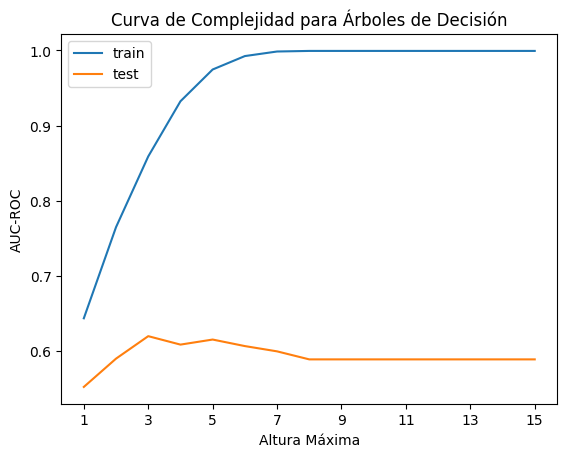

In [ ]:
#1
import matplotlib.pyplot as plt

train_scores_matriz = []
test_scores_matriz  = []
alturas = range(1, 16, 1)

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=2025)

for train_index, test_index in kf.split(X_dev, y_dev):
    kf_X_train, kf_X_test = X_dev.iloc[train_index], X_dev.iloc[test_index]
    kf_y_train, kf_y_test = y_dev.iloc[train_index], y_dev.iloc[test_index]

    train_scores = []
    test_scores  = []

    for depth in alturas:
        arbol = DecisionTreeClassifier(max_depth=depth,
                              criterion=search_arbol.best_params_['criterion'],
                              min_samples_split=search_arbol.best_params_['min_samples_split'],
                              min_impurity_decrease=search_arbol.best_params_['min_impurity_decrease'],
                              random_state=2025)
        arbol.fit(kf_X_train, kf_y_train)

        train_scores.append(roc_auc_score(kf_y_train, arbol.predict_proba(kf_X_train)[:,1]))
        test_scores.append(roc_auc_score(kf_y_test, arbol.predict_proba(kf_X_test)[:,1]))

    train_scores_matriz.append(train_scores)
    test_scores_matriz.append(test_scores)

mean_train_scores = np.mean(np.array(train_scores_matriz), axis=0)
mean_test_scores  = np.mean(np.array(test_scores_matriz),  axis=0)

plt.plot(alturas, mean_train_scores, label='train')
plt.plot(alturas, mean_test_scores, label='test')
plt.xticks(range(1,16,2))
plt.title("Curva de Complejidad para Árboles de Decisión")
plt.xlabel("Altura Máxima")
plt.ylabel("AUC-ROC")
plt.legend()

Valor de C que maximiza:  9.154110733752406


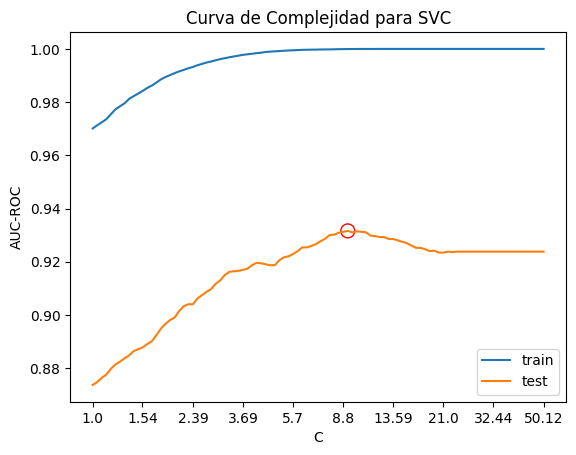

In [ ]:
train_scores_matriz = []
test_scores_matriz  = []

Cs = np.logspace(0, 1.7, 100)
kf = StratifiedKFold(n_splits=6, shuffle=True, random_state=2025)

for train_index, test_index in kf.split(X_dev, y_dev):

    kf_X_train, kf_X_test = X_dev.iloc[train_index], X_dev.iloc[test_index]
    kf_y_train, kf_y_test = y_dev.iloc[train_index], y_dev.iloc[test_index]

    train_scores = []
    test_scores  = []

    for c in Cs:
        svc = SVC(C=c, gamma=search_svc.best_params_['gamma'],
                         kernel=search_svc.best_params_['kernel'])
        svc.fit(kf_X_train, kf_y_train)

        train_scores.append(roc_auc_score(kf_y_train, svc.decision_function(kf_X_train)))
        test_scores.append(roc_auc_score(kf_y_test, svc.decision_function(kf_X_test)))

    train_scores_matriz.append(train_scores)
    test_scores_matriz.append(test_scores)

mean_train_scores = np.mean(np.array(train_scores_matriz), axis=0)
mean_test_scores  = np.mean(np.array(test_scores_matriz),  axis=0)

C_max = Cs[np.argmax(mean_test_scores)]
print("Valor de C que maximiza: ", C_max)
max_test = np.max(mean_test_scores)

plt.plot(np.log10(Cs), mean_train_scores, label='train')
plt.plot(np.log10(Cs), mean_test_scores , label='test')
plt.scatter(np.log10(C_max), max_test, s=100, edgecolor='red', facecolor='none')

ticks = np.logspace(0, 1.7, 10).round(2)
plt.xticks(np.log10(ticks), ticks)

plt.title("Curva de Complejidad para SVC")
plt.xlabel("C")
plt.ylabel("AUC-ROC")
plt.legend()

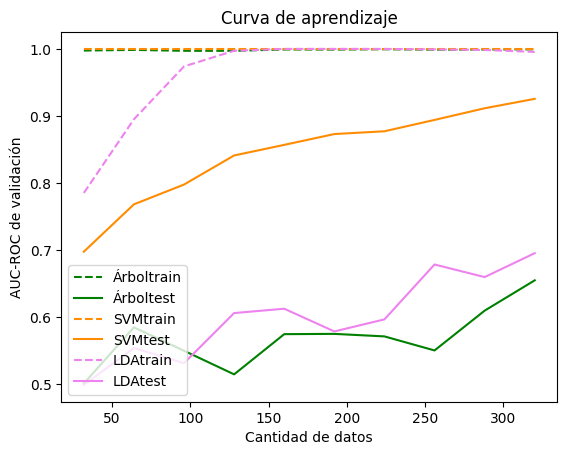

In [ ]:
#2
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

#en curva de aprendizaje quiero:
#eje x =  datos train
#eje y = métrica

#especifico los mejores modelos
modelos = {
    'Árbol': DecisionTreeClassifier(criterion=search_arbol.best_params_['criterion'],
                                    min_samples_split=search_arbol.best_params_['min_samples_split'],
                                    min_impurity_decrease=search_arbol.best_params_['min_impurity_decrease'],
                                    max_depth=search_arbol.best_params_["max_depth"],
                                    random_state=2025),
    'SVM': SVC(C=search_svc.best_params_["C"], kernel=search_svc.best_params_["kernel"], gamma=search_svc.best_params_['gamma']),
    'LDA': LinearDiscriminantAnalysis()
}
#aca usamos la funcion de curvas de aprendizaje ya implementada

colores = {'Árbol': 'green', 'SVM': 'darkorange', 'LDA': 'violet'}

for nombre, modelo in modelos.items():
    train_sizes, train_scores, test_scores = learning_curve(
        modelo, X_dev, y_dev, cv=5, scoring="roc_auc",
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=2025
    )
    plt.plot(train_sizes, train_scores.mean(axis=1), '--' , color=colores[nombre], label=nombre + 'train')
    plt.plot(train_sizes, test_scores.mean(axis=1), color=colores[nombre], label=nombre + 'test')
#si no llegara a correr con roc_auc, usar make_scorer(roc_auc_score), parece que esta forma usa la implementación interna optimizada de scikit-learn

plt.title("Curva de aprendizaje")
plt.xlabel("Cantidad de datos")
plt.ylabel("AUC-ROC de validación")
plt.legend(loc='lower left')
plt.show()



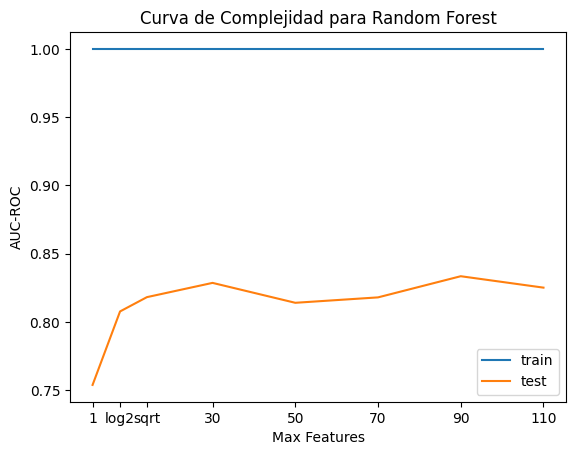

In [ ]:
#3
from sklearn.ensemble import RandomForestClassifier

#random_forest=RandomForestClassifier(n_estimators= 200,random_state=2025,max_features=None) #, criterion='entropy',max_depth= 6
n_features=X_dev.shape[1]



#curva de complejidad:
train_scores_matriz_rf = []
test_scores_matriz_rf  = []
max_features=[1,'log2','sqrt',30,50,70,90,110]
kf = StratifiedKFold(n_splits=6, shuffle=True, random_state=2025)

for train_index, test_index in kf.split(X_dev, y_dev):

    kf_X_train, kf_X_test = X_dev.iloc[train_index], X_dev.iloc[test_index]
    kf_y_train, kf_y_test = y_dev.iloc[train_index], y_dev.iloc[test_index]

    train_scores = []
    test_scores  = []

    for max_feature in max_features:
        random_forest=RandomForestClassifier(n_estimators= 200,random_state=2025,max_features=max_feature) #, criterion='entropy',max_depth= 6

        random_forest.fit(kf_X_train, kf_y_train)

        train_scores.append(roc_auc_score(kf_y_train, random_forest.predict_proba(kf_X_train)[:,1]))
        test_scores.append(roc_auc_score(kf_y_test, random_forest.predict_proba(kf_X_test)[:,1]))

    train_scores_matriz_rf.append(train_scores)
    test_scores_matriz_rf.append(test_scores)

mean_train_scores = np.mean(np.array(train_scores_matriz_rf), axis=0)
mean_test_scores  = np.mean(np.array(test_scores_matriz_rf),  axis=0)

ticks = [1, np.log2(200), np.sqrt(200),30,50,70,90,110]

plt.plot(ticks, mean_train_scores, label='train')
plt.plot(ticks, mean_test_scores, label='test')
plt.xticks(ticks, max_features)
plt.title("Curva de Complejidad para Random Forest")
plt.xlabel("Max Features")
plt.ylabel("AUC-ROC")
plt.legend()

cómo no le puse restricciones a los árboles, sobre
 ajusta mucho a los datos de entrenamiento.

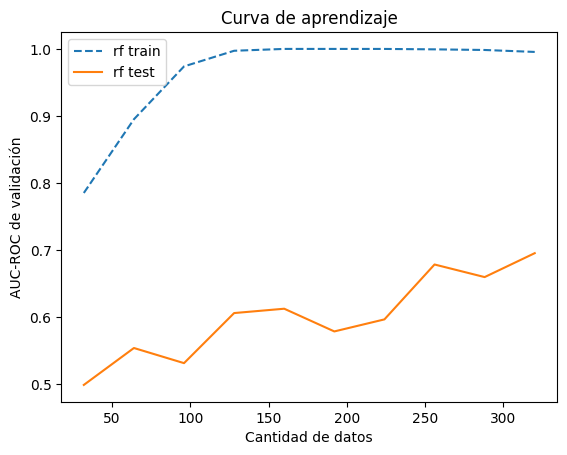

In [ ]:
random_forest=RandomForestClassifier(n_estimators= 200,random_state=2025,max_features='sqrt',max_depth=20)
train_sizes, train_scores, test_scores = learning_curve(
        modelo, X_dev, y_dev, cv=5, scoring="roc_auc",
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=2025
    )
plt.plot(train_sizes, train_scores.mean(axis=1), '--' , label='rf train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='rf test')

plt.title("Curva de aprendizaje")
plt.xlabel("Cantidad de datos")
plt.ylabel("AUC-ROC de validación")
plt.legend()
plt.show()

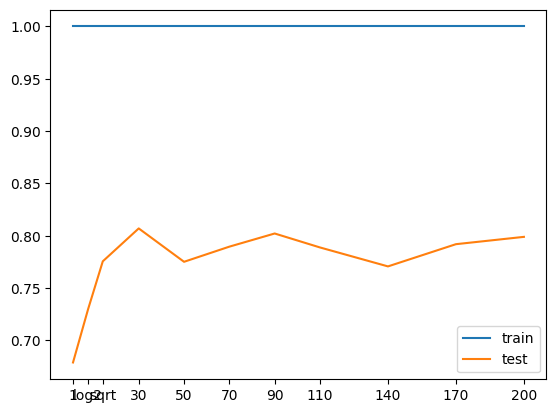

In [ ]:
#3
from sklearn.ensemble import RandomForestClassifier

#random_forest=RandomForestClassifier(n_estimators= 200,random_state=2025,max_features=None) #, criterion='entropy',max_depth= 6
n_features=X_dev.shape[1]



#curva de complejidad:
train_scores_matriz_rf = []
test_scores_matriz_rf  = []
max_features=[1,'log2','sqrt',30,50,70,90,110,140,170,200]
kf = StratifiedKFold(n_splits=6, shuffle=True, random_state=2025)

for train_index, test_index in kf.split(X_dev, y_dev):

    kf_X_train, kf_X_test = X_dev.iloc[train_index], X_dev.iloc[test_index]
    kf_y_train, kf_y_test = y_dev.iloc[train_index], y_dev.iloc[test_index]

    train_scores = []
    test_scores  = []

    for max_feature in max_features:
        random_forest=RandomForestClassifier(n_estimators=50, random_state=2025,max_features=max_feature,max_depth=20) #, criterion='entropy',max_depth= 6

        random_forest.fit(kf_X_train, kf_y_train)

        train_scores.append(roc_auc_score(kf_y_train, random_forest.predict_proba(kf_X_train)[:,1]))
        test_scores.append(roc_auc_score(kf_y_test, random_forest.predict_proba(kf_X_test)[:,1]))

    train_scores_matriz_rf.append(train_scores)
    test_scores_matriz_rf.append(test_scores)

mean_train_scores = np.mean(np.array(train_scores_matriz_rf), axis=0)
mean_test_scores  = np.mean(np.array(test_scores_matriz_rf),  axis=0)

ticks = [1, np.log2(200), np.sqrt(200),30,50,70,90,110,140,170,200]

plt.plot(ticks, mean_train_scores, label='train')
plt.plot(ticks, mean_test_scores, label='test')
plt.xticks(ticks, max_features)
plt.legend()

## Ejercicio 5 - Evaluación de performance


In [32]:
svc = SVC(C=C_max,probability=True, gamma=search_svc.best_params_['gamma'],
                kernel=search_svc.best_params_['kernel'])
svc.fit(X_dev, y_dev)

probs_eval = svc.predict_proba(X_eval)

print('score dev', roc_auc_score(y_dev, svc.decision_function(X_dev)))
print('score eval', roc_auc_score(y_eval, svc.decision_function(X_eval)))
print('score eval via probs', roc_auc_score(y_eval, probs_eval[:, 1]))

catedra_X_held_out = pd.read_csv('catedra_X_held_out.csv')
catedra_y_held_out = svc.predict_proba(catedra_X_held_out)[:, 1]

display(catedra_y_held_out[catedra_y_held_out > 0.5])

np.savetxt("17_y_pred_held_out_8786.csv", catedra_y_held_out, header="output",delimiter=".",fmt="%.4f")


score dev 0.9998518913474925
score eval 0.8785714285714286
score eval via probs 0.8785714285714286


array([0.92747142, 0.98423597, 0.66255361, 0.87253699, 0.94743768,
       0.92872038, 0.95960537, 0.98946593, 0.99998544, 0.77079959,
       0.99559907, 0.99999968, 0.69535939, 0.53966114, 0.65375812,
       0.73020825, 0.91077082, 0.56280295, 0.74756838, 0.90140599,
       0.99008245, 0.94265868, 0.51574599, 0.98189493, 0.72360217,
       0.63595035, 0.76682111, 0.84235361, 0.66356155, 0.90317028,
       0.97466339, 0.87585034, 0.63135636, 0.86198177, 0.98552338,
       0.53869967, 0.60505917, 0.59291605, 0.57157529, 0.54324841,
       0.98616792, 0.78810553, 0.75593627, 0.81201893, 0.59870397,
       0.72248236, 0.51597901, 0.92715482, 0.52328505, 0.99732862,
       0.95009155, 0.54143027, 0.63436291, 0.756595  , 0.68830412,
       0.6630604 , 0.88020509, 0.84298678, 0.64914114, 0.99585956,
       0.85704203, 0.97749702, 0.94361679, 0.58102841, 0.7520811 ,
       0.91085418, 0.85882723, 0.99999514, 0.88288611, 0.66060715,
       0.74778135, 0.83466808, 0.75122047, 0.75937238, 0.66892